In [1]:
from synapse.video_loader.read_frames import fetch_metadata_from_zarr

# video_zarr = "gs://induction-labs/youtube-output-2/X5T3gN09oEg.zarr"
# video_zarr = "gs://induction-labs/jeffrey/test_video.zarr"
video_zarr = "gs://induction-labs/jonathan/synth/cursor_follow_v3/sample_3.zarr"
# video_zarr = "gs://induction-labs/jonathan/synth/cursor_follow_v0/sample_0.zarr"
# video_zarr = "gs://induction-labs/jonathan/synth/typing_v0/sample_0.zarr"
# video_zarr = "gs://induction-labs/jonathan/synth/garbage_cursor_follow_v0/sample_0.zarr"
video_metadata = await fetch_metadata_from_zarr(video_zarr)
video_metadata

I0723 17:34:15.789894 2241066 google_auth_provider.cc:149] Using credentials at /home/ubuntu/.config/gcloud/application_default_credentials.json
I0723 17:34:15.790058 2241066 google_auth_provider.cc:156] Using OAuth2 AuthProvider


StreamMetadata(input_video=VideoMetadata(fps=Fraction(4, 1), total_frames=17, resolution=840x476, start_pts=0, duration=17, time_base=Fraction(1, 4)), output_video=FramesMetadata(fps=Fraction(4, 1), total_frames=17, resolution=840x476), output_frames_per_chunk=17)

In [4]:
for i in range(50):
  video_zarr = "gs://induction-labs/jonathan/synth/cursor_follow_v3/sample_{}.zarr".format(i)
  video_metadata = await fetch_metadata_from_zarr(video_zarr)
  if video_metadata.output_video.resolution.pixels != 840*476:
    print("Video {} has resolution {}".format(i, video_metadata.output_video.resolution))
    raise ValueError("Unexpected resolution for video {}".format(i))

  if video_metadata.output_video.total_frames < 16:
    print("Video {} has too few frames: {}".format(i, video_metadata.output_video.total_frames))
    # raise ValueError("Video {} has too few frames".format(i))

Video 1 has too few frames: 13
Video 6 has too few frames: 15
Video 9 has too few frames: 13
Video 10 has too few frames: 11
Video 15 has too few frames: 13
Video 17 has too few frames: 15
Video 18 has too few frames: 15
Video 22 has too few frames: 15
Video 24 has too few frames: 13
Video 25 has too few frames: 15
Video 26 has too few frames: 15
Video 28 has too few frames: 11
Video 29 has too few frames: 13
Video 31 has too few frames: 15
Video 32 has too few frames: 15
Video 38 has too few frames: 11
Video 40 has too few frames: 15
Video 41 has too few frames: 15
Video 42 has too few frames: 15
Video 43 has too few frames: 13
Video 48 has too few frames: 13


In [29]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np



def render_zarr_frame(frame: np.ndarray, coords: tuple[int,int] | None = None) -> np.ndarray:
    assert frame.ndim == 3, "Input should be a 4D numpy array with shape (C, H, W)"

    # Convert from (C, H, W) to (H, W, C) format for display
    frame = np.transpose(frame, (1, 2, 0))

    # Display the frame
    plt.figure(figsize=(10, 8))
    plt.imshow(frame)

    if coords is not None:
        # Draw a red dot at the specified coordinates
        plt.scatter(coords[0], coords[1], color='red', s=100, label='Mouse Cursor')
        plt.legend()
    # plt.title(f"Frame {frame_number}")
    plt.axis("off")
    plt.show()

    return frame

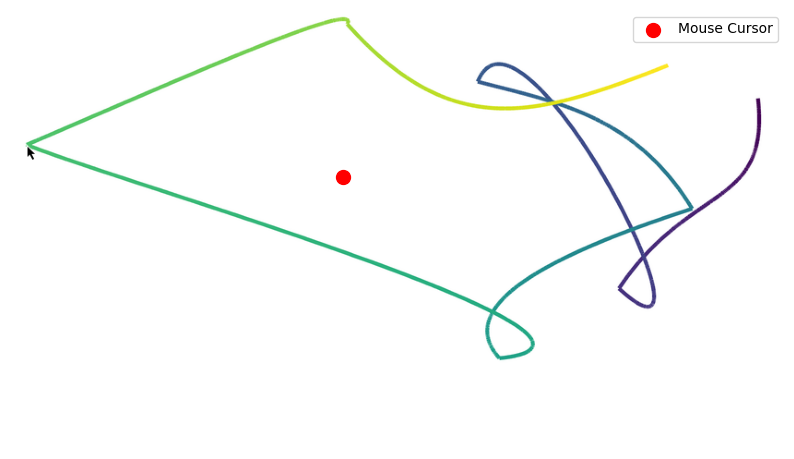

In [116]:
from synapse.video_loader.read_frames import fetch_frames_from_zarr
i=25
video_zarr = f"gs://induction-labs/jonathan/synth/cursor_follow_v3/sample_{i}.zarr"
video_metadata = await fetch_metadata_from_zarr(video_zarr)
frame_number =11
# i += 1

frames = await fetch_frames_from_zarr(video_zarr, (frame_number, frame_number + 1))
_ =  render_zarr_frame(frames[0], coords=(360,181))

Closest index for timestamp 1750083739 with timestamp_pts=26881286231040 is 1291, value: 26881286232566 (1750083739.099349s)


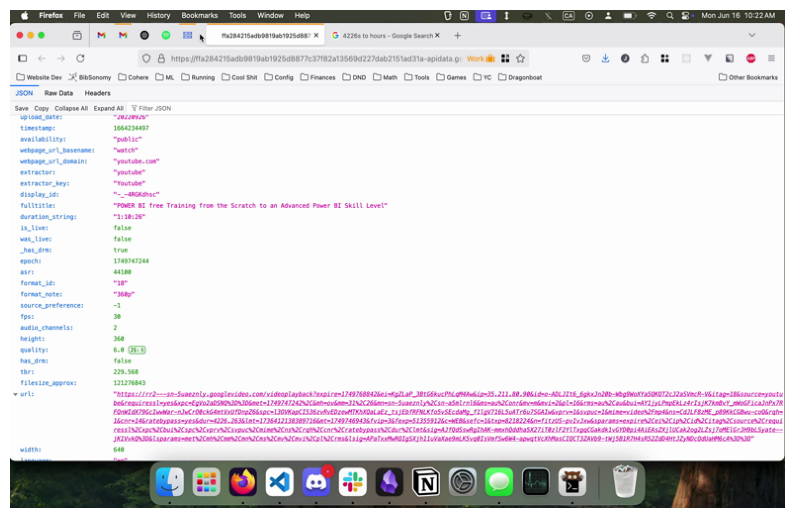

In [15]:
from synapse.video_loader.read_frames import get_frame_at_timestamp
# timestamp =240.0  # Example timestamp in seconds
# timestamp = float(video_metadata.start_time +20 )
timestamp = 486134 * 60 * 60+22 * 60+19
frame_at_timestamp = await get_frame_at_timestamp(video_zarr, timestamp)
_ = await render_zarr_frame(frame_at_timestamp)

In [23]:
from __future__ import annotations

import av
import numpy as np


from video_reader import PyVideoReader


import matplotlib.pyplot as plt
import numpy as np



def decode_single_frame_to_array(
    video_path: str, target_frame_idx: int = 400, fmt: str = "rgb24"
) -> np.ndarray:
    """
    Decode the frame at index `target_frame_idx` (zero-based) from `video_path`
    and return it as an HxWxC NumPy array in the specified pixel format (default 'rgb24').

    Raises:
        IndexError: if the video has fewer than target_frame_idx+1 frames.
    """
    container = av.open(video_path)
    stream = container.streams.video[0]

    for idx, frame in enumerate(container.decode(video=0)):
        if idx == target_frame_idx:
            # Convert to HxWxC NumPy array
            arr = frame.to_ndarray(format=fmt)
            container.close()
            # Convert to CHW format if needed
            # arr = np.transpose(arr, (2, 0, 1)) if fmt == "rgb24" else arr
            return arr

    container.close()
    raise IndexError(
        f"Video contains only {idx + 1} frames; cannot get frame {target_frame_idx}."
    )


def decode_single_frame_pyvideo(
    video_path: str, target_frame_idx: int = 400
) -> np.ndarray:
    """
    Decode the frame at index `target_frame_idx` (zero-based) from `video_path`
    using PyVideoReader and return it as an HxWxC NumPy array in RGB format.

    Raises:
        IndexError: if the video has fewer than target_frame_idx+1 frames.
    """
    vr = PyVideoReader(video_path)
    # total_frames = vr.get_info()["frame_count"]

    # if target_frame_idx >= total_frames:
    #     raise IndexError(
    #         f"Video contains only {total_frames} frames; cannot get frame {target_frame_idx}."
    #     )

    frame = vr.decode(start_frame=target_frame_idx, end_frame=target_frame_idx+1)[0]
    return frame


frame1.shape=(480, 640, 3), frame2.shape= (480, 640, 3)


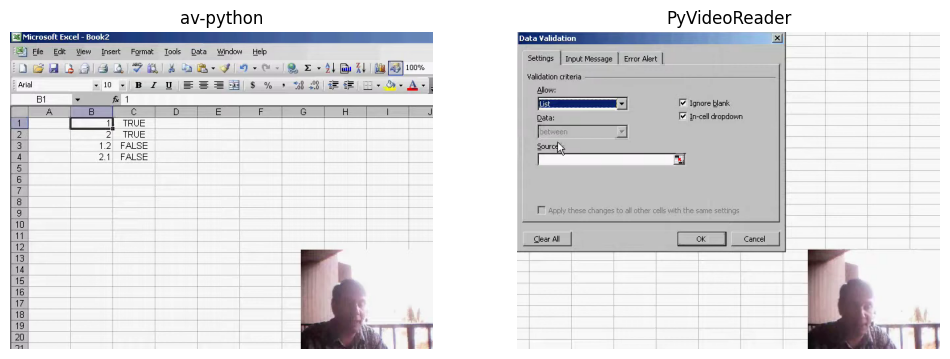

In [24]:
path = "/home/jeffrey_inductionlabs_com/documents/induction-labs/repos/synapse/test_data/output.mp4"
frame_number = 960
frame1 = decode_single_frame_to_array(path, frame_number)
frame2 = decode_single_frame_pyvideo(path, frame_number)
print(f"{frame1.shape=}, {frame2.shape= }")
# Display the frames side by side for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(frame1)
plt.title("av-python")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(frame2)
plt.title("PyVideoReader")
plt.axis("off")
plt.show()
